In [1]:
from datetime import datetime, timedelta
import pickle
import copy

from package.query import *
from package.plot import *
from package.data_mgt import *
from package.seriealize import *
from package.dic_mgt import *

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34883, 35171, 35616, 35566, 35731, 35973, 36261', '34762, 34705, 34934, 35236, 35178, 35365, 35590', '34589, 34752, 34603, 34641, 34728, 34687, 34759', '34783, 34698, 35155, 35051, 35409, 35260, 35665', '34151, 33989, 34076, 34520, 34471, 34635, 34150', '34919, 35106, 35128, 35407, 35449, 35711', '34765, 35174, 35645, 35878, 36199, 36842, 37129', '34787, 34942, 35139, 35420, 35681, 35867, 36058', '34605, 34744, 34927, 35131, 35186, 35341, 35496', '34690, 34639, 34801, 34848, 34895, 35054, 35100']
serialized list :  [[34883, 35171, 35616, 35566, 35731, 35973, 36261], [34762, 34705, 34934, 35236, 35178, 35365, 35590], [34589, 34752, 34603, 34641, 34728, 34687, 34759], [34783, 34698, 35155, 35051, 35409, 35260, 35665], [34151, 33989, 34076, 34520, 34471, 34635, 34150], [34919, 35106, 35128, 35407, 35449, 35711, 35711], [34765, 35174, 35645, 35878, 36199, 36842, 37129], [34787, 34942, 35139, 35420, 35681, 35867, 36058]

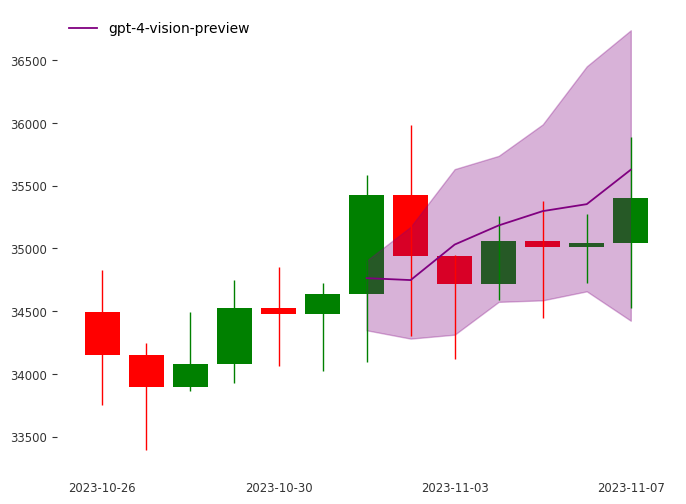

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34582, 34737, 34678, 34833, 34774, 34929, 34870', '34741, 34616, 34566, 34731, 34681, 34796, 34746', '34703, 34746, 34784, 34816, 34843, 34866, 34885', '34684, 34617, 34642, 34729, 34703, 34754, 34778', '34663, 34676, 34684, 34689, 34692, 34694, 34695', '34839, 35134, 35298, 35467, 35679, 35741, 35906', '34799, 34857, 35002, 35122, 35238, 35343, 35462', '34636, 34907, 34884, 34732, 34956, 34997, 34930', '34905, 35452, 35060, 34762, 35089, 35449, 35442', '34588, 34709, 34726, 34917, 34916, 35004, 35029']
serialized list :  [[34582, 34737, 34678, 34833, 34774, 34929, 34870], [34741, 34616, 34566, 34731, 34681, 34796, 34746], [34703, 34746, 34784, 34816, 34843, 34866, 34885], [34684, 34617, 34642, 34729, 34703, 34754, 34778], [34663, 34676, 34684, 34689, 34692, 34694, 34695], [34839, 35134, 35298, 35467, 35679, 35741, 35906], [34799, 34857, 35002, 35122, 35238, 35343, 35462], 

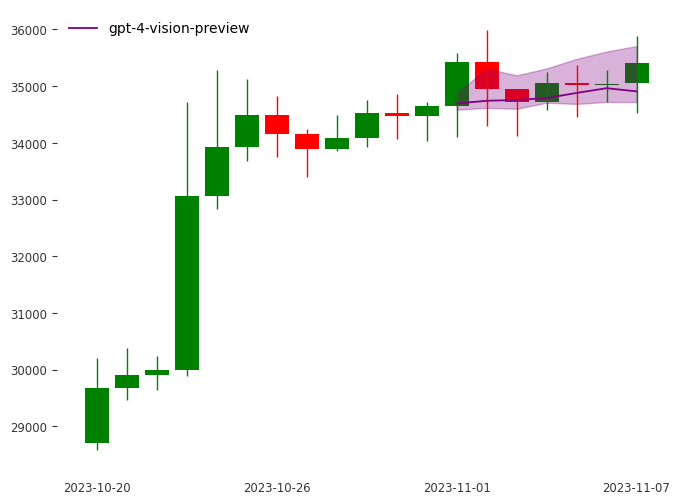

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34610, 34557, 34562, 34500, 34421, 34389, 34330', '34648, 34580, 34503, 34557, 34873, 35438, 35859', '34621, 34678, 34639, 34657, 34656, 34659, 34658', '34570, 34678, 34584, 34873, 35261, 35670, 35992', '34557, 34627, 34810, 35112, 35295, 35482, 35671', '34668, 34722, 34739, 34744, 34747, 34749, 34750', '35089, 35548, 36490, 36857, 36914, 37012, 37320', '34615, 34589, 34574, 34566, 34561, 34559, 34558', '34663, 34919, 35094, 35187, 35223, 35250, 35305', '34430, 34222, 34002, 33790, 33520, 33243, 33160']
serialized list :  [[34610, 34557, 34562, 34500, 34421, 34389, 34330], [34648, 34580, 34503, 34557, 34873, 35438, 35859], [34621, 34678, 34639, 34657, 34656, 34659, 34658], [34570, 34678, 34584, 34873, 35261, 35670, 35992], [34557, 34627, 34810, 35112, 35295, 35482, 35671], [34668, 34722, 347

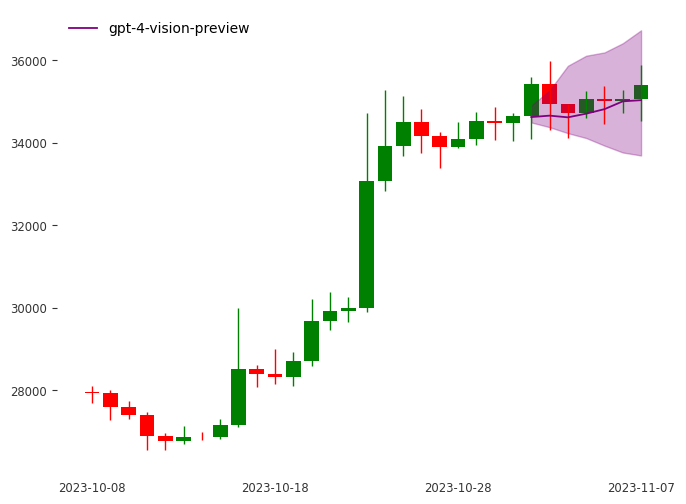

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ["I'm sorry, but as an AI, I cannot continue this sequence without a clear pattern or algorithm. Time series predictions typically require analyzing the structure or trend of a given dataset, which might involve complex calculations or models. Since this sequence does not follow a simple arithmetic or geometric progression, or any other immediately discernible pattern, I cannot accurately predict the next terms. If there is a specific pattern or rule that the sequence follows, please provide it so I can try to help.", "I'm sorry, but I'm unable to continue the sequence as it does not follow a clear mathematical or logical patter

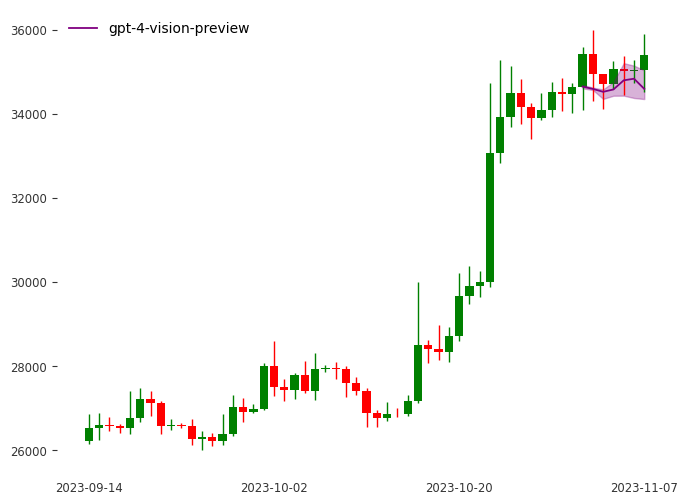

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34544, 34409, 34274, 34139, 34004, 33869, 33734', '34534, 34498, 34448, 34400, 34355, 34313, 34274', '34675, 35059, 35249, 35479, 36037, 35265, 35422', '34692, 34748, 34729, 34885, 34902, 34921, 35011', '34610, 34564, 34561, 34593, 34712, 34711, 34701', '34684, 34605, 34884, 34906, 34910, 35143, 3

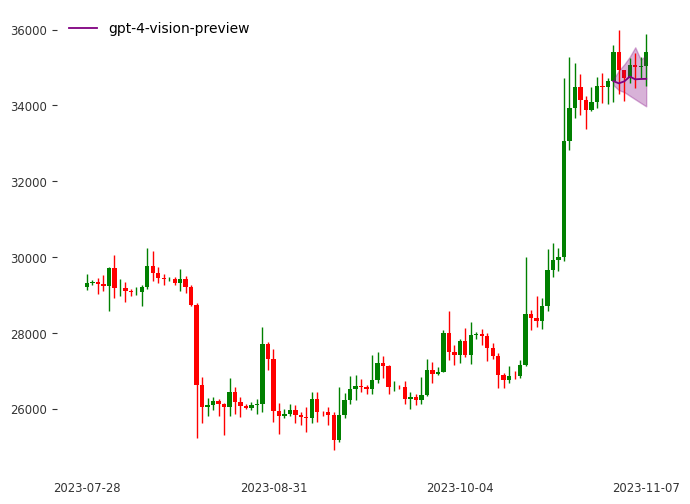

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

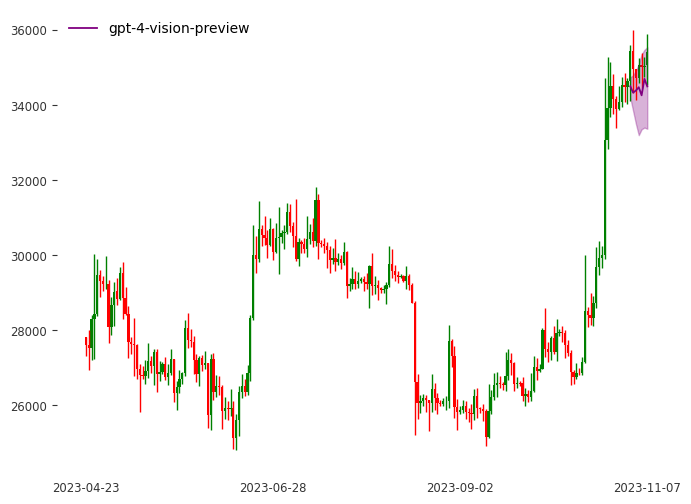

In [2]:
make_prediction(mode = "naive", data = "bitcoin", setup = None, model = "gpt-4-vision-preview")

In [3]:
all_naive_dic = make_dic_MAE_MSE("naive")

dic_error :
{'input_length': {6: {'Mae': [[539.1311324621565, 229.5613064233694, 898.879542611663, 502.9447514835265, 718.0535351700019, 927.096726418742, 861.2234133746533], [660.1311324621565, 236.4386935766306, 216.87954261166306, 172.9447514835265, 165.05353517000185, 319.09672641874204, 190.22341337465332], [833.1311324621565, 189.4386935766306, 114.12045738833694, 422.0552485164735, 284.94646482999815, 358.90327358125796, 640.7765866253467], [639.1311324621565, 243.4386935766306, 437.87954261166306, 12.055248516473512, 396.05353517000185, 214.09672641874204, 265.2234133746533], [1271.1311324621565, 952.4386935766306, 641.120457388337, 543.0552485164735, 541.9464648299981, 410.90327358125796, 1249.7765866253467], [503.13113246215653, 164.5613064233694, 410.87954261166306, 343.9447514835265, 436.05353517000185, 665.096726418742, 311.2234133746533], [657.1311324621565, 232.5613064233694, 927.879542611663, 814.9447514835265, 1186.0535351700019, 1796.096726418742, 1729.2234133746533],

In [4]:
display_tab(all_naive_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length      Mae     Mse
--------------  -------  ------
             6  479.982  326302
            12  373.357  214631
            24  498.702  392044
            48  452.897  264368
            96  442.669  276410
           192  688.447  611296
Mean error with 5 days forecasting
  input_length      Mae     Mse
--------------  -------  ------
             6  450.771  293349
            12  329.036  164216
            24  532.464  490829
            48  440.449  243987
            96  435.362  272941
           192  715.211  737205
Mean error with 7 days forecasting
  input_length      Mae     Mse
--------------  -------  ------
             6  495.086  383459
            12  337.208  167755
            24  610.81   650178
            48  471.86   294373
            96  465.37   330249
           192  746.431  848907
##############################
Median MAE/MSE
Median error with 3 days forecasting
  input_length      Mae     M

Input str :  -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['107, -63, 80, 23, -92, 72, -52', '212, 243, 107, 291, 390, 211, 548', '86, 67, -71, -84, 88, 107, -56', '-121, -70, 71, 142, -30, 96, -142', '69, -144, 171, -39, 192, 3, 213', '85, -136, 171, -204, 220, -253, 279', '149, -36, 68, 203, -49, 104, 287', '117, -31, 97, 108, -46, 88, 100', '163, -191, 524, -1159, 2772, -6587, 15730', '102, 145, -35, 68, 192, 203, -55']
int list return
[[107, -63, 80, 23, -92, 72, -52], [212, 243, 107, 291, 390, 211, 548], [86, 67, -71, -84, 88, 107, -56], [-121, -70, 71, 142, -30, 96, -142], [69, -144, 171, -39, 192, 3, 213], [85, -136, 171, -204, 220, -253, 279], [149, -36, 68, 203, -49, 104, 287], [117, -31, 97, 108, -46, 88, 100], [163, -191, 524, -1159, 2772, -6587, 15730], [102, 145, -35, 68, 192, 203, -55]]
int list, close
[[35011.39465005757, 34790.82286376221, 35069.14944667231, 35149.80849039966, 34826.43025228798, 35077.18055010446, 34894.77921124391], [35375.12240688513, 36234.73788137243

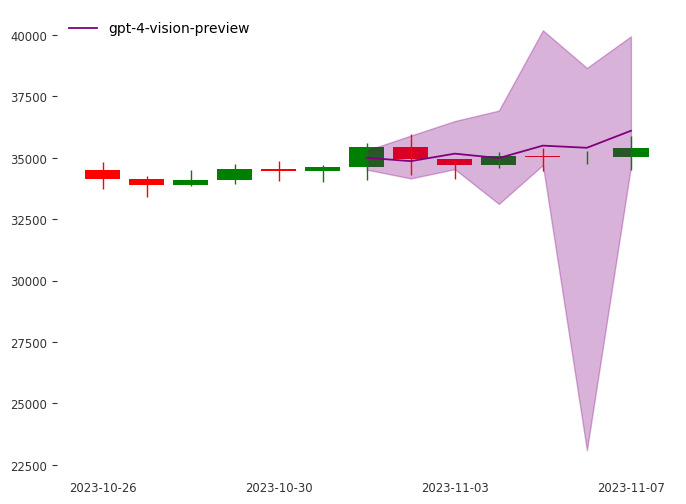

Input str :  333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-272, 164, 680, -226, -340, 1364, -454', '125, -98, 108, 119, -121, 68, 113', '59, -1, 40, 67, 17, 32, 75', '-9, 20, -3, 8, -1, 4, -1', '54, 117, -12, 45, 60, 108, -9', 'Sorry, but I am unable to provide the continuation of the sequence without additional context or information on the pattern or rule governing the progression of the numbers given in the sequence.', '106, -3, 63, -89, 81, -5, 70', '-26, 33, -9, 24, -2, 15, 6', '-7, 176, 370, -72, -20, 50, 65', '-84, -14, 62, 125, -29, 40, -98']
error in serialization
int list return
[[-272, 164, 680, -226, -340, 1364, -454], [125, -98, 108, 119, -121, 68, 113], [59, -1, 40, 67, 17, 32, 75], [-9, 20, -3, 8, -1, 4, -1], [54, 117, -12, 45, 60, 108, -9], [106, -3, 63, -89, 81, -5, 70], [-26, 33, -9, 24, -2, 15, 6], [-7, 176, 370, -72, -20, 50, 65], [-84, -14, 62, 125, -29, 40, -98]]
int list, close
[[33698.51065160385, 34251.16622629015, 36580.2455296778

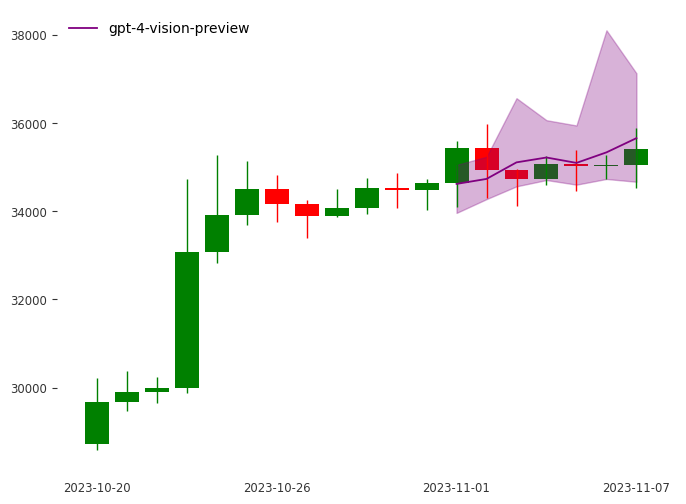

Input str :  -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['237, -66, -45, 170, 411, 114, 73', '383, -74, -10, 167, 294, 101, 71', '117, 604, 63, 76, 361, 898, 147', '327, -29, 15, 87, 219, -7, 22', '213, 702, 604, 506, 408, 310, 212', '637, 631, 1019, 370, 1187, 881, 1359', '74, -615, -172, -57, 307, 873, 204', '46, 37, 168, 262, 91, 63, 1135', '155, -33, 176, 59, -2, 63, 179', '892, -38, -19, 113, 243, 72, 49']
int list return
[[237, -66, -45, 170, 411, 114, 73], [383, -74, -10, 167, 294, 101, 71], [117, 604, 63, 76, 361, 898, 147], [327, -29, 15, 87, 219, -7, 22], [213, 702, 604, 506, 408, 310, 212], [637, 631, 1019, 370, 1187, 881, 1359], [74, -615, -172, -57, 307, 873, 204], [46, 37, 168, 262, 91, 63, 1135], [155, -33, 176, 59, -2, 63, 179], [892, -38, -19, 113, 243, 72, 49]]
int list, close
[[35461.72425374883, 35227.676873674085, 35069.15232774255, 35665.32791731417, 37131.17289471578, 37554.

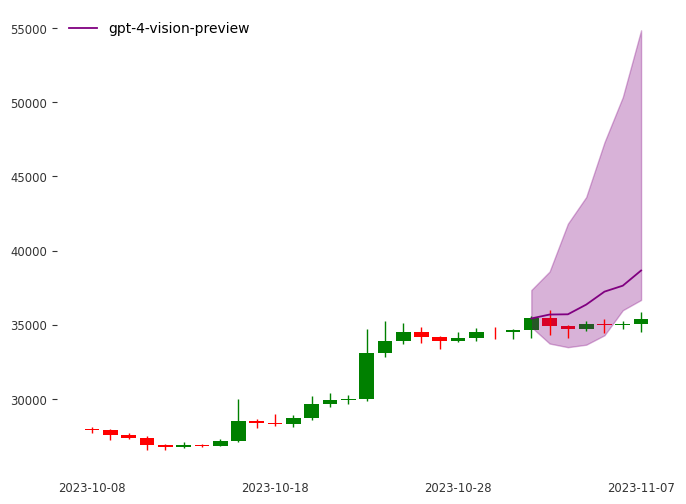

Input str :  115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-149, -10, -190, 267, 55, 84, 1498', '-50, 25, 936, 309, 151, -69, -123', '311, -342, 85, 2027, 560, -82, 320', '-310, 328, 219, 57, -49, -231, -78', '-177, -263, -74, 215, 494, 172, 57', '-22, -38, -189, 11, 35, -8, 216', 'Please provide the pattern to the sequence for further assistance.', '-244, -35, -41, 228, 314, -208, 88', '233, -214, -29, 158, -121, 220, 25', '-287, -13, -70, 197, 579, 168, 62']
error in serialization
int list return
[[-149, -10, -190, 267, 55, 84, 1498], [-50, 25, 936, 309, 151, -69, -123], [311, -342, 85, 2027, 560, -82, 320], [-310, 328, 219, 57, -49, -231, -78], [-177, -263, -74, 215, 494, 172, 57], [-22, -38, -189, 11, 35, -8, 216], [-244, -35, -41, 228, 314, -208, 88], [233, -214, -29, 158, -121, 22

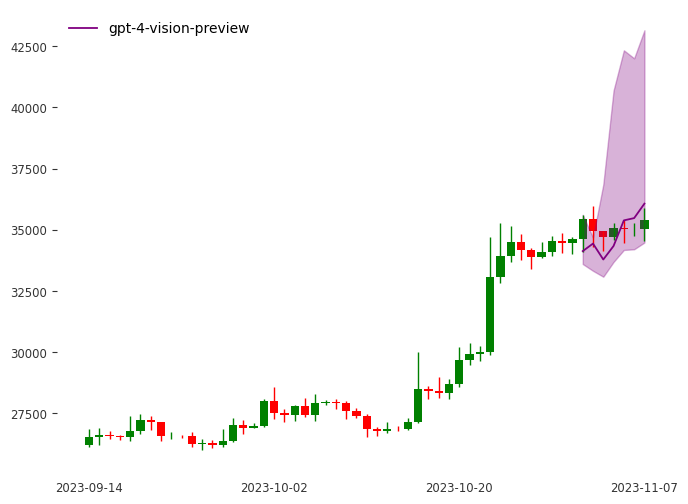

Input str :  31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-472, 63, -387, -84, 32, 48, -65', '-8, -11, 159, -109, 103, 298, -174', '-76, -28, 48, 19, -79, 161, -322', '66, -2, 20, 56, 432, 181, 251', '-98, -624, -74, 18, 85, 412, 19', '-57, 29, 65, -38, -104, 328, -205', '-215, -6, 166, 269, 218, -140, 29', '-173, -230, 602, 730, 287, 9, 135', '-13, 111, -76, -7, 40, -101, -225', '-116, -44, 31, 237, 412, 116, -3']
int list return
[[-472, 63, -387, -84, 32, 48, -65], [-8, -11, 159, -109, 103, 298, -174], [-76, -28, 48, 19, -79, 161, -322], [66, -2, 20, 56, 432

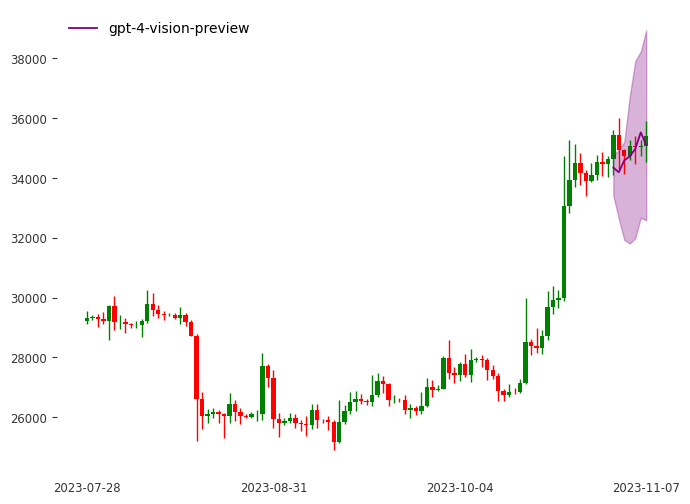

Input str :  -81, -29, 287, 41, 372, -55, -28, 1, -399, 214, 124, -65, 232, -222, -145, -268, -15, -11, -228, -64, -8, 53, 91, -47, 137, -213, 22, 83, -131, 38, 138, -327, 55, 88, 56, 451, -117, -15, -175, -144, 158, -64, 17, -511, 584, -327, 61, -8, -240, 33, -8, 11, -311, 187, 292, 65, -67, 192, 545, 596, -37, 269, -52, -21, -64, 140, -200, 123, 8, 37, 10, 176, -125, -85, -199, 150, -20, -41, 83, 69, -79, 354, -363, -7, -19, -31, -92, 17, -37, 34, -36, 97, -302, 18, 42, -44, 31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-637, 23, -60, 263, -32, -263, 245', '-

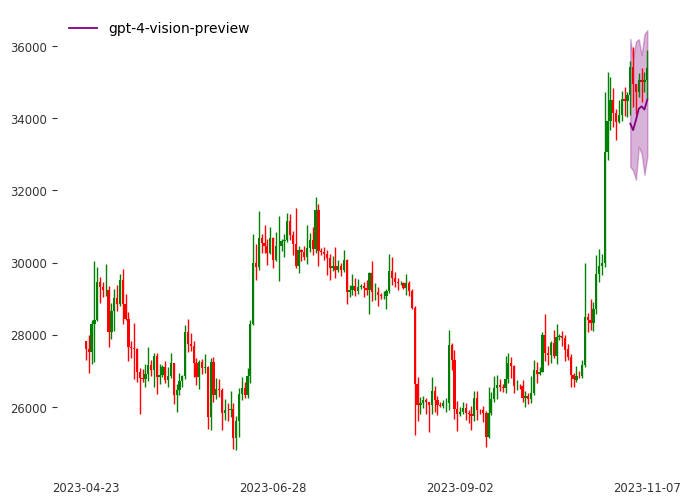

In [6]:
make_prediction(mode = "return", data = "bitcoin", setup = None, model = "gpt-4-vision-preview")

In [7]:
all_return_dic = make_dic_MAE_MSE("return")

dic_error :
{'input_length': {6: {'Mae': [[410.73648240458715, 150.6158298144219, 352.0289892839719, 86.75324188318336, 186.51621254201746, 31.27727652320027, 504.9973753814338], [47.00872557702678, 1293.2991877958048, 1905.3291193147816, 2625.107610868705, 4145.054746071197, 4938.3317628699515, 6775.5945298233855], [483.48203377009486, 231.29935407666198, 205.89115012661932, 433.3969385046439, 78.5471616900686, 262.2941021022634, 289.30511624565406], [1200.5453258015477, 959.4039875626477, 493.81330496165174, 353.7771345253277, 407.7961851808286, 108.5435512474578, 958.5273723486825], [542.3712896374127, 563.9473924885606, 248.22594494833902, 234.07369714890956, 484.7515323238258, 462.44403297171084, 864.8985175572016], [486.9461076446387, 481.37218509663217, 332.21318838666775, 728.7280091152788, 76.73597383802553, 843.9898006115327, 243.62972775976232], [265.24537967356446, 88.88227050191927, 551.406689245945, 921.4229991944812, 795.2078394671698, 1134.6558354805966, 1819.1645688665

In [8]:
display_tab(all_return_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   537.739  481114
            12   580.489  589905
            24  1618.39        5.9629e+06
            48  1028.17        1.5461e+06
            96   978.952       1.63648e+06
           192  1450.37        2.62794e+06
Mean error with 5 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   791.294       1.77566e+06
            12   510.473  460309
            24  2432.64        1.42283e+07
            48  1375.74        4.81213e+06
            96  1132.32        2.38633e+06
           192  1286.71        2.1798e+06
Mean error with 7 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6  1220.44        8.81467e+06
            12   592.212  777674
            24  3393.04        3.19334e+07
            48  1622

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, U4, U4, U2, D2, U2', 'D2, U2, U2, D2, U2, U2, U2', 'D2, U2, D2, U4, D4, U6, D8', 'D2, U2, U2, U4, D2, U2, U2', 'U2, U2, U2, U2, U2, U2, U2', 'D2, U2, D4, U2, D2, U4, U2', 'U2, U2, U4, U4, U6, U8, U10', 'D2, U2, D2, U2, D2, U2, D2', 'D2, U2, U2, D2, U2, U2, D2', 'D2, U2, U2, D2, D2, U2, U2']
serialized :  [[-1, 1, 3, 3, 1, -1, 1], [-1, 1, 1, -1, 1, 1, 1], [-1, 1, -1, 3, -3, 5, -7], [-1, 1, 1, 3, -1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [-1, 1, -3, 1, -1, 3, 1], [1, 1, 3, 3, 5, 7, 9], [-1, 1, -1, 1, -1, 1, -1], [-1, 1, 1, -1, 1, 1, -1], [-1, 1, 1, -1, -1, 1, 1]]
int list, close
[[34294, 34636, 35675, 36745, 37112, 36740, 37107], [34294, 34636, 34982, 34632, 34978, 35327, 35680], [34294, 34636, 34289, 35317, 34257, 35969, 33451], [34294, 34636, 34982, 36031, 35670, 36026, 36386], [34987, 35336, 35689, 36045, 36405, 36769, 37136], [34294, 34636, 33596, 33931, 33591, 34598, 34943], [34987, 35336, 36396, 37487, 39361, 4

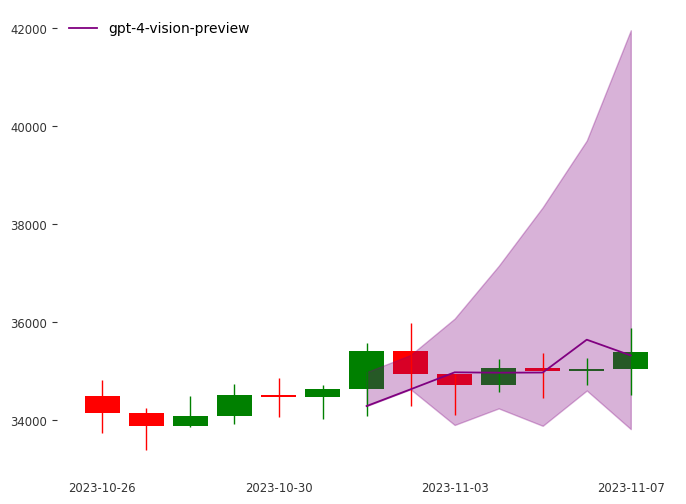

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, U2, U2, U2, U2, U2', 'U2, U2, D2, D2, D4, D4, D6', 'To continue the given sequence, I first need to understand the pattern of the changes in terms of the provided bins. Let\'s look at the percentage changes and map them to the bins:\n\n1. 29670 to 29910: This is an increase of about 0.81%, which falls into the "U2" bin.\n2. 29910 to 29993: This is an increase of about 0.28%, which falls into the "U2" bin.\n3. 29993 to 33070: This is an increase of about 10.26%, which falls into the "U10+" bin.\n4. 33070 to 33922: This is an increase of about 2.58%, which falls into the "U4" bin.\n5. 33922 to 34496: This is an increase of about 1.69%, which falls into the "U2" bin.\n6. 34496 to 34152: This is a decrease of about 1%, which falls into the "D2" bin.\n7. 34152 to 33893: This is a decrease of about 0.76%, which falls into the "D2" bin.\n8. 33893 to 34081: This is an incre

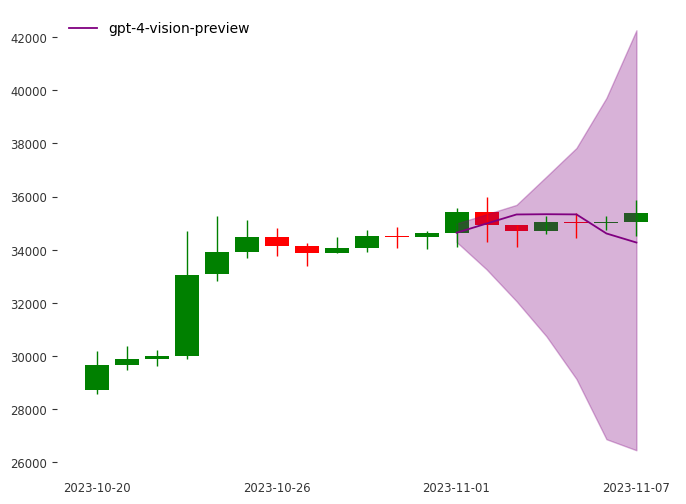

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, D2, U2, U2, U2, U2, U2', 'D2, D2, U2, D2, U2, U2, U2', 'U2, U2, D2, D2, U2, U2, U2', 'D4, D2, U2, U2, U2, U2, U4', 'D2, D2, D2, U2, U2, D2, D2', 'D2, D2, U2, D2, U2, D2, U2', 'D2, D2, U2, D2, D2, U2, U2', 'D2, D2, U2, U2, U2, U2, U2', 'D2, U2, D2, D4, D2, U2, D2', 'D2, D2, D4, D2, U2, U2, U2']
serialized :  [[-1, -1, 1, 1, 1, 1, 1], [-1, -1, 1, -1, 1, 1, 1], [1, 1, -1, -1, 1, 1, 1], [-3, -1, 1, 1, 1, 1, 3], [-1, -1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, 1, -1, 1], [-1, -1, 1, -1, -1, 1, 1], [-1, -1, 1, 1, 1, 1, 1], [-1, 1, -1, -3, -1, 1, -1], [-1, -1, -3, -1, 1, 1, 1]]
int list, close
[[34294, 33951, 34290, 34632, 34978, 35327, 35680], [34294, 33951, 34290, 33947, 34286, 34628, 34974], [34987, 35336, 34982, 34632, 34978, 35327, 35680], [33601, 33264, 33596, 33931, 34270, 34612, 35650], [342

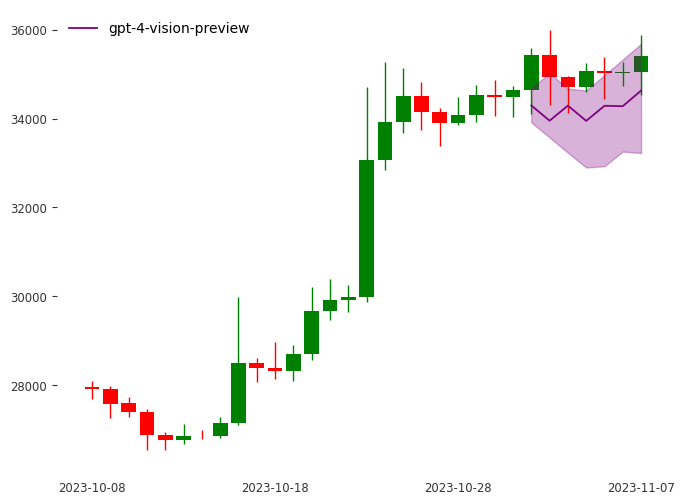

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, U2, U2, U2, U2, U2', 'U2, U2, U4, U6, U8, U10, U10+', 'D2, D4, D6, D8, D10, D10+, U2', 'U2, U2, U4, U4, U6, U8, U10', 'D2, D4, D6, D8, D10, D10+, U2', 'D2, D2, D4, D6, D8, D10, D10+', 'U2, U2, D2, D2, D4, D4, D6', 'U6, U8, U10, U10+, U10, U8, U6', 'D2, U2, U2, D2, D4, D8, D10', 'D2, D4, D6, D4, D2, U2, U4']
serialized :  [[1, 1, 1, 1, 1, 1, 1], [1, 1, 3, 5, 7, 9, 11], [-1, -3, -5, -7, -9, -11, 1], [1, 1, 3, 3, 5, 7, 9], [-1, -3, -5, -7, -9, -11, 1], [-1, -1, -3, -5, -7, -9, -11], [1, 1, -1, -1, -3, -3, -5], [5, 7, 9, 11, 9, 7, 5], [-1, 1, 1, -1, -3, -7, -9], [-1, -3, -5, -3, -1, 1, 3]]
int list, close
[[34987, 35336, 3

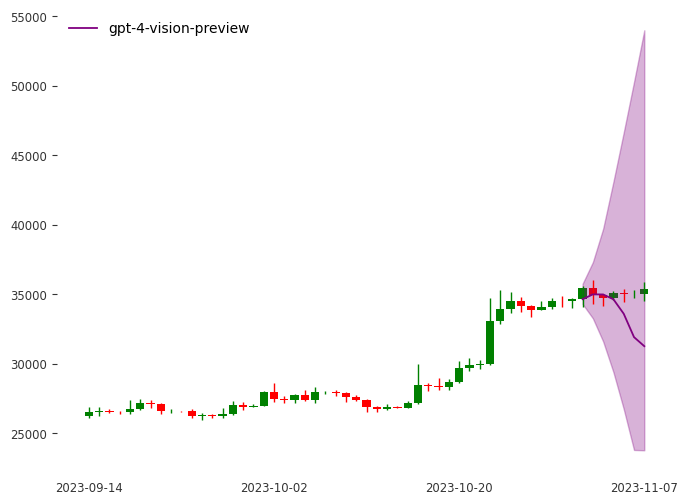

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, D2, D4, U2, D4, D6, D8', 'D2, U2, U4, U4, U6, U8, U10', 'D2, D4, D6, D8, D10, D10+, D10+', 'U10+, U10+, U10+, U10+, U10+, U8, U6', 'U10+, U10+, U10+, U10+, U10+, U10+, U10+', 'D4, D6, D8, D10, D10+, U2, U4', 'D4, D2, D2, D4, D6, D8, D10', 'U2, U2, D2, D4, D6, D8, D10', 'U10, U8, U6, U4, U2, D2

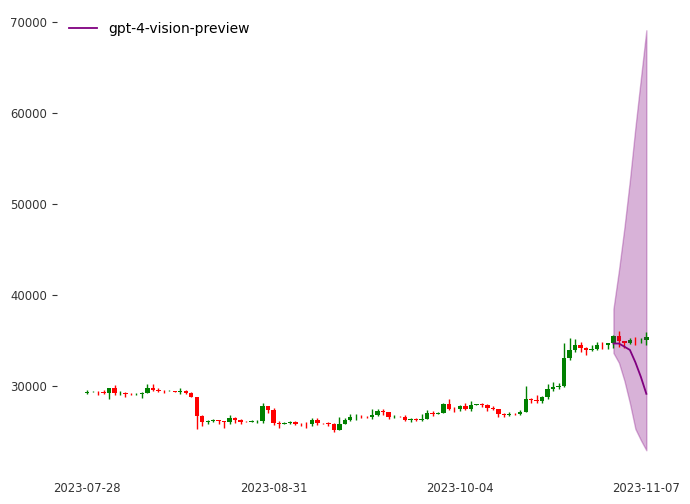

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

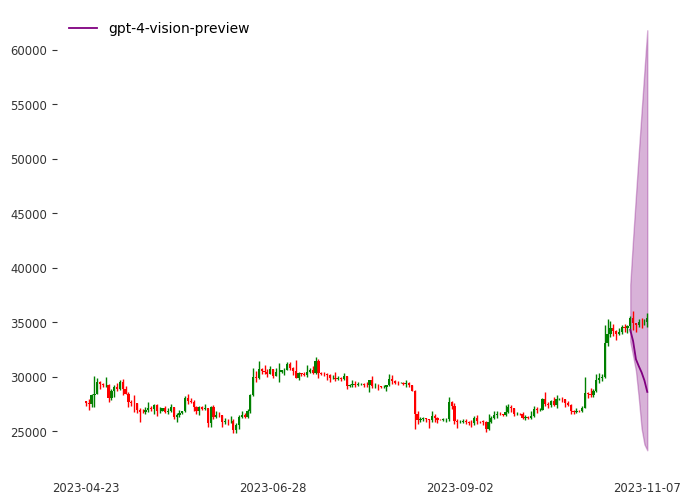

In [2]:
make_prediction(mode = "bin", data = "bitcoin", setup = None, model = "gpt-4-vision-preview")

In [3]:
all_bin_dic = make_dic_MAE_MSE("bin")

dic_error :
{'input_length': {6: {'Mae': [[1128.1311324621565, 305.4386935766306, 957.879542611663, 1681.9447514835265, 2099.053535170002, 1694.096726418742, 1707.2234133746533], [1128.1311324621565, 305.4386935766306, 264.87954261166306, 431.0552485164735, 34.94646482999815, 281.09672641874204, 280.2234133746533], [1128.1311324621565, 305.4386935766306, 428.12045738833694, 253.9447514835265, 755.9464648299981, 923.096726418742, 1948.7765866253467], [1128.1311324621565, 305.4386935766306, 264.87954261166306, 967.9447514835265, 657.0535351700019, 980.096726418742, 986.2234133746533], [435.13113246215653, 394.5613064233694, 971.879542611663, 981.9447514835265, 1392.0535351700019, 1723.096726418742, 1736.2234133746533], [1128.1311324621565, 305.4386935766306, 1121.120457388337, 1132.0552485164735, 1421.9464648299981, 447.90327358125796, 456.7765866253467], [435.13113246215653, 394.5613064233694, 1678.879542611663, 2423.9447514835265, 4348.053535170002, 7070.096726418742, 10506.22341337465

In [4]:
display_tab(all_bin_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   659.115  606756
            12   914.45        1.25277e+06
            24   914.426       1.01498e+06
            48  1463.56        4.41127e+06
            96  3134.28        2.09443e+07
           192  3173.37        1.82333e+07
Mean error with 5 days forecasting
  input_length       Mae          Mse
--------------  --------  -----------
             6   822.827  1.20473e+06
            12  1379.92   4.12636e+06
            24   943.836  1.18789e+06
            48  2815.64   1.82242e+07
            96  5063.67   5.71945e+07
           192  4878.51   4.70329e+07
Mean error with 7 days forecasting
  input_length      Mae          Mse
--------------  -------  -----------
             6  1071.1   3.45104e+06
            12  2037.22  1.07024e+07
            24   937.3   1.22382e+06
            48  4558.19  4.43441e+07
            96  7222

In [3]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "APD/"

dict_error_APD = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                130: {"Mae": None, "Mse": None}}}

dict_error_APD_median = copy.deepcopy(dict_error_APD)

for input_length in [6, 12, 24, 48, 96, 130] :

    df_raw, train, test = get_data_darts(input_length)   
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    final_dic = basic_seriealize(list_response)
    print("int list APD")
    print(final_dic)

    full_Mae_dict, full_Mse_dict = MAE_MSE_calculator(final_dic, df_raw, input_length)
    dict_error_APD["input_length"][input_length]["Mae"] = full_Mae_dict.copy()
    dict_error_APD["input_length"][input_length]["Mse"] = full_Mse_dict.copy()

    full_Mae_dict_median, full_Mse_dict_median = MAE_MSE_median_calculator(final_dic, df_raw, input_length)
    dict_error_APD_median["input_length"][input_length]["Mae"] = full_Mae_dict_median.copy()
    dict_error_APD_median["input_length"][input_length]["Mse"] = full_Mse_dict_median.copy()

    index_save += 1
    current_folder = savefig + str(index_save)
    # plot_pred_classic(df_raw, train, final_dic, "gpt-4-vision-preview",  savefig = current_folder)


with open('pickle/dic_error_APD.pkl', 'wb') as fichier:
    pickle.dump(dict_error_APD, fichier)

with open('pickle/dic_error_APD_median.pkl', 'wb') as fichier:
    pickle.dump(dict_error_APD_median, fichier)




Input str :  112, 118, 132, 129, 121, 135, 
GPT Answer :  ["144, 150, 141, 147, 159, 156, 148\n\nExplanation:\nThe given sequence can be divided into two distinct patterns that alternate:\n\nPattern 1 (starting from the first term): 112, 132, 121, 141\nPattern 2 (starting from the second term): 118, 129, 135\n\nIn pattern 1, we can observe the following:\n112 + 20 = 132\n132 - 11 = 121\n121 + 20 = 141\n\nFollowing this pattern, we will get:\n141 - 11 = 130, but we have to make sure it fits into the overall sequence, so let's check pattern 2 as well.\n\nIn pattern 2, we have increments of 11, then 6:\n118 + 11 = 129\n129 + 6 = 135\n\nWe can predict the next increments by continuing this (subtracting 5 from the previous increment):\n11 - 5 = 6 (already used)\n6 - 5 = 1\n1 - 5 = -4 (since we can't increment by a negative number, we will need to adjust this to fit with pattern 1's outcome)\n\nSo, incrementing the last number of each pattern by these values, we get:\n141 - 11 = 130 (however

In [2]:
with open('pickle/dic_error_APD.pkl', 'rb') as fichier:
    dict_error_APD = pickle.load(fichier)

with open('pickle/dic_error_APD_median.pkl', 'rb') as fichier:
    dict_error_APD_median = pickle.load(fichier)

list_of_length = [6, 12, 24, 48, 96, 130]

get_specific_dic(list_of_length)

dic_error_3_APD = get_specific_dic(list_of_length)
dic_error_5_APD = get_specific_dic(list_of_length)
dic_error_7_APD = get_specific_dic(list_of_length)

dic_error_3_APD_median = get_specific_dic(list_of_length)
dic_error_5_APD_median = get_specific_dic(list_of_length)
dic_error_7_APD_median = get_specific_dic(list_of_length)

print(dict_error_APD)
dic_mgt(dict_error_APD, dic_error_3_APD, dic_error_5_APD, dic_error_7_APD)
dic_mgt(dict_error_APD_median, dic_error_3_APD_median, dic_error_5_APD_median, dic_error_7_APD_median)

print(dic_error_3_APD)

{'input_length': {6: {'Mae': [[16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 14.0, 12.0, 26.0, 33.0, 33.0, 43.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 12.0, 14.0, 36.0, 47.0, 47.0, 57.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 12.0, 18.0, 34.0, 43.0, 45.0, 57.0], [6.0, 12.0, 12.0, 26.0, 33.0, 33.0, 43.0], [6.0, 14.0, 12.0, 26.0, 33.0, 33.0, 43.0]], 'Mse': [[256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 196.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 144.0, 196.0, 1296.0, 2209.0, 2209.0, 3249.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 144.0, 324.0, 1156.0, 1849.0, 2025.0, 3249.0], [36.0, 144.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0], [36.0, 196.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0]]}, 12: {'Mae': [[17.

In [3]:
print("Global MAE/MSE")
table_display(dic_error_3_APD)
table_display(dic_error_5_APD)
table_display(dic_error_7_APD)

print("##############################")
print("Median MAE/MSE")
table_display(dic_error_3_APD_median)
table_display(dic_error_5_APD_median)
table_display(dic_error_7_APD_median)

Global MAE/MSE
  input_length       Mae       Mse
--------------  --------  --------
             6  12.4      204.533
            12  12.9333   265.067
            24   8.46667  125
            48  12.2333   215.767
            96   7.33333   83.7333
           130  11.1333   168.467
  input_length    Mae     Mse
--------------  -----  ------
             6  18.08  437.32
            12  14.44  347.88
            24  10.16  168.48
            48  14.38  286.62
            96   7.78   90.58
           130  15.4   391.48
  input_length      Mae      Mse
--------------  -------  -------
             6  22.4     667.171
            12  17.4     519.286
            24  11.7     289.186
            48  14.7857  382.014
            96  13.0857  871.543
           130  15.7143  391.914
##############################
Median MAE/MSE
  input_length      Mae       Mse
--------------  -------  --------
             6  12.3333  177
            12  13.5     255.75
            24   6        53.1667
 